# Numerical Simulator

In [6]:
from quantum_optimizer import QuantumState, cmaes_optimize, scipy_optimize, Qfunction, plot_fidelity_progress, plot_comparison, cmawm_optimize, gkp_state
import qutip as qt
import numpy as np

Running CMA-ES Optimization...
 evals    1 - Fidelity
13000      0.037338
CMA-ES Optimization Complete!

Running Scipy Optimization...
Current 1 - Fidelity = 0.328721
Scipy Optimization Complete!
Plotting inverse fidelity progress comparison...


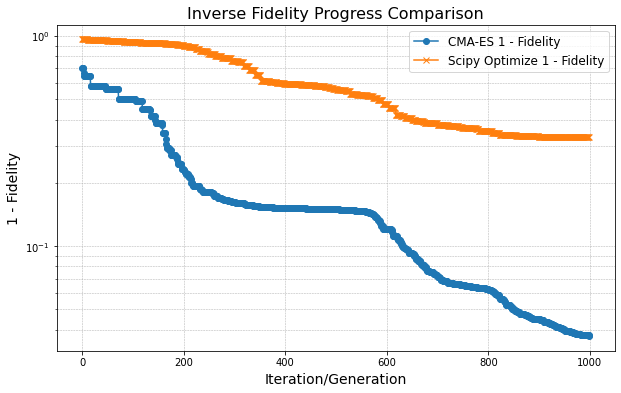

Plotting Q-functions for CMA-ES and Scipy...


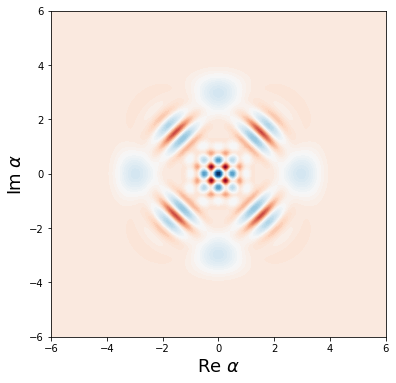

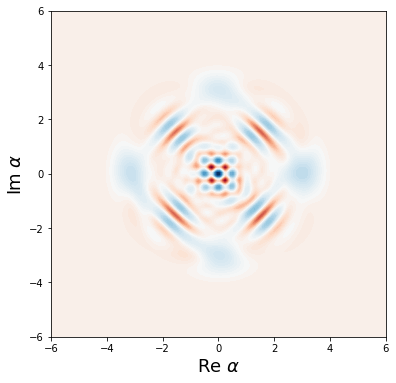

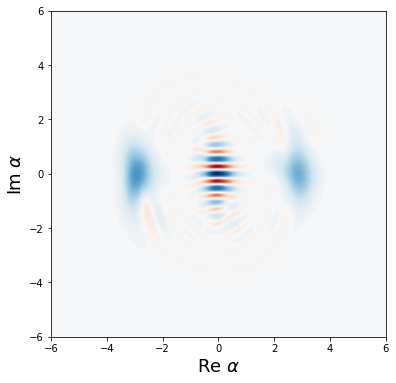

In [9]:
def main():
    # System parameters
    Nq = 2
    Nc = 18
    N_blocks = 6

    # Define initial and target states
    psi_g = qt.tensor(qt.basis(Nq, 0), qt.basis(Nc, 0))
    psi_t = (qt.tensor(qt.basis(2,1), (qt.coherent(Nc,3)+qt.coherent(Nc,-3)+qt.coherent(Nc,3j)+qt.coherent(Nc,-3j)).unit()))

    # Initialize QuantumState
    qs = QuantumState(N_blocks=N_blocks, Nq=Nq, Nc=Nc, initial_state=psi_g, final_state=psi_t)

    # CMA-ES Optimization
    print("Running CMA-ES Optimization...")
    best_params_cmaes, fidelity_progress_cmaes = cmawm_optimize(qs, sigma=10.0, max_generations=1000)
    print("\nCMA-ES Optimization Complete!")

    # Scipy Optimization
    print("\nRunning Scipy Optimization...")
    result_scipy, fidelity_progress_scipy = scipy_optimize(qs, method="nelder-mead", max_iterations=1000)
    print("\nScipy Optimization Complete!")

    # Plot inverse fidelity progress for both methods
    print("Plotting inverse fidelity progress comparison...")
    plot_comparison(fidelity_progress_cmaes, fidelity_progress_scipy)

    # Extract final state from CMA-ES results
    betas_cmaes = [complex(best_params_cmaes[i], best_params_cmaes[i + 1]) for i in range(0, 2 * N_blocks, 2)]
    phis_cmaes = best_params_cmaes[2 * N_blocks:3 * N_blocks]
    thetas_cmaes = best_params_cmaes[3 * N_blocks:4 * N_blocks]
    final_state_cmaes = qs.gate_sequence(betas_cmaes, phis_cmaes, thetas_cmaes, N_blocks)

    # Extract final state from Scipy results
    best_params_scipy = result_scipy.x
    betas_scipy = [complex(best_params_scipy[i], best_params_scipy[i + 1]) for i in range(0, 2 * N_blocks, 2)]
    phis_scipy = best_params_scipy[2 * N_blocks:3 * N_blocks]
    thetas_scipy = best_params_scipy[3 * N_blocks:4 * N_blocks]
    final_state_scipy = qs.gate_sequence(betas_scipy, phis_scipy, thetas_scipy, N_blocks)

    # Plot Q-functions of final states
    print("Plotting Q-functions for CMA-ES and Scipy...")
    Qfunction(psi_t)
    Qfunction(final_state_cmaes)
    Qfunction(final_state_scipy)
    
if __name__ == "__main__":
    main()

In [ ]:
import matplotlib.pyplot as plt
import qutip as qt
import numpy as np

def main():
    # System parameters
    Nq = 2
    Nc = 12
    max_N_blocks = 10

    # Define initial and target states
    psi_g = qt.tensor(qt.basis(Nq, 0), qt.basis(Nc, 0))
    psi_t = (qt.tensor(qt.basis(2,1), (qt.coherent(Nc,3)))+qt.tensor(qt.basis(2,1), (qt.coherent(Nc,-3)))+qt.tensor(qt.basis(2,1), (qt.coherent(Nc,3j)))+qt.tensor(qt.basis(2,1), (qt.coherent(Nc,-3j)))).unit()

    # Initialize results
    fidelity_scipy = []
    fidelity_cmaes = []

    # Loop over N_blocks from 1 to max_N_blocks
    for N_blocks in range(1, max_N_blocks + 1):
        print(f"\nRunning optimization for N_blocks = {N_blocks}...")

        # Initialize QuantumState with the current N_blocks
        qs = QuantumState(N_blocks=N_blocks, Nq=Nq, Nc=Nc, initial_state=psi_g, final_state=psi_t)

        # CMA-ES Optimization
        print("Running CMA-ES Optimization...")
        best_params_cmaes, _ = cmawm_optimize(qs, sigma=10.0, max_generations=1000)
        print("CMA-ES Optimization Complete!")

        # Scipy Optimization
        print("Running Scipy Optimization...")
        result_scipy, _ = scipy_optimize(qs, method="nelder-mead", max_iterations=1000)
        print("Scipy Optimization Complete!")

        # Extract final states and compute fidelity for CMA-ES
        betas_cmaes = [complex(best_params_cmaes[i], best_params_cmaes[i + 1]) for i in range(0, 2 * N_blocks, 2)]
        phis_cmaes = best_params_cmaes[2 * N_blocks:3 * N_blocks]
        thetas_cmaes = best_params_cmaes[3 * N_blocks:4 * N_blocks]
        final_state_cmaes = qs.gate_sequence(betas_cmaes, phis_cmaes, thetas_cmaes, N_blocks)
        fidelity_cmaes.append(qt.fidelity(final_state_cmaes, psi_t))

        # Extract final states and compute fidelity for Scipy Optimize
        best_params_scipy = result_scipy.x
        betas_scipy = [complex(best_params_scipy[i], best_params_scipy[i + 1]) for i in range(0, 2 * N_blocks, 2)]
        phis_scipy = best_params_scipy[2 * N_blocks:3 * N_blocks]
        thetas_scipy = best_params_scipy[3 * N_blocks:4 * N_blocks]
        final_state_scipy = qs.gate_sequence(betas_scipy, phis_scipy, thetas_scipy, N_blocks)
        fidelity_scipy.append(qt.fidelity(final_state_scipy, psi_t))

        print(f"Fidelity CMA-ES: {fidelity_cmaes[-1]:.6f}")
        print(f"Fidelity Scipy Optimize: {fidelity_scipy[-1]:.6f}")

    # Plot fidelity vs. N_blocks
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_N_blocks + 1), fidelity_cmaes, label="CMA-ES", marker='o')
    plt.plot(range(1, max_N_blocks + 1), fidelity_scipy, label="Scipy Optimize", marker='x')
    plt.xlabel("N_blocks", fontsize=14)
    plt.ylabel("Fidelity", fontsize=14)
    plt.title("Fidelity vs. N_blocks", fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

if __name__ == "__main__":
    main()



Running optimization for N_blocks = 1...
Running CMA-ES Optimization...
 evals    1 - Fidelity
CMA-ES Optimization Complete!
Running Scipy Optimization...
Optimization terminated successfully.
         Current function value: 0.540715
         Iterations: 233
         Function evaluations: 469
Scipy Optimization Complete!

Running optimization for N_blocks = 2...
Running CMA-ES Optimization...
 evals    1 - Fidelity
CMA-ES Optimization Complete!
Running Scipy Optimization...
Optimization terminated successfully.
         Current function value: 0.496403
         Iterations: 839
         Function evaluations: 1458
Scipy Optimization Complete!

Running optimization for N_blocks = 3...
Running CMA-ES Optimization...
 evals    1 - Fidelity


KeyboardInterrupt: 

In [49]:
Nq = 2
Nc = 18
N_blocks = 9

# Define initial and target states
psi_g = qt.tensor(qt.basis(Nq, 0), qt.basis(Nc, 0))
psi_t = (qt.tensor(qt.basis(2,1), (qt.coherent(Nc,3)+qt.coherent(Nc,-3)+qt.coherent(Nc,3j)+qt.coherent(Nc,-3j)).unit()))

# Initialize QuantumState
qs = QuantumState(N_blocks=N_blocks, Nq=Nq, Nc=Nc, initial_state=psi_g, final_state=psi_t)

# Scipy Optimization
print("\nRunning Scipy Optimization...")
result_scipy, fidelity_progress_scipy = scipy_optimize(qs, method="BFGS", max_iterations=1000)
print("\nScipy Optimization Complete!")

# Extract final state from Scipy results
best_params_scipy = result_scipy.x
betas_scipy = [complex(best_params_scipy[i], best_params_scipy[i + 1]) for i in range(0, 2 * N_blocks, 2)]
phis_scipy = best_params_scipy[2 * N_blocks:3 * N_blocks]
thetas_scipy = best_params_scipy[3 * N_blocks:4 * N_blocks]
final_state_scipy = qs.gate_sequence(betas_scipy, phis_scipy, thetas_scipy, N_blocks)


Running Scipy Optimization...


c:\Users\Russell\OneDrive\Documents\Harvard\Courses\AM207\Project\quantum_optimizer\optimizers.py:55: RuntimeWarning: Method BFGS cannot handle bounds.
  result = optimize.minimize(


         Current function value: 0.070795
         Iterations: 197
         Function evaluations: 7696
         Gradient evaluations: 208

Scipy Optimization Complete!


c:\Users\Russell\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [51]:
best_params_scipy

array([ 3.65764836,  2.29316723,  1.56569243,  1.94759963,  1.7946324 ,
        0.08871088,  1.41475389,  1.58784755,  0.57438754, -0.09043747,
        0.9382648 ,  2.73583469,  0.41150288,  1.24310887,  1.03296436,
       -0.21366282,  0.08884192,  3.10439942, -1.46234836,  5.14566989,
        0.66874819, -0.65978289,  2.30690842,  0.35283504,  0.90851589,
       -0.58685356,  2.83004332,  1.67201008,  2.08041332,  3.80450801,
        1.57249355,  1.04466966,  1.59010455,  1.00421787,  2.04666059,
        0.71493299])

In [53]:
best_params_scipy = result_scipy.x
betas_scipy = [complex(best_params_scipy[i], best_params_scipy[i + 1]) for i in range(0, 2 * N_blocks, 2)]
phis_scipy = best_params_scipy[2 * N_blocks:3 * N_blocks]
thetas_scipy = best_params_scipy[3 * N_blocks:4 * N_blocks]
final_state_scipy = qs.gate_sequence(betas_scipy, phis_scipy, thetas_scipy, N_blocks)
qt.fidelity(psi_g, final_state_scipy)

np.float64(0.06343424487135556)

In [ ]:
# Fidelity density map for modifying the first two elements of betas_scipy

# Parameters
beta_1_range = np.linspace(0, 6*np.pi, 200)  # Range for the first beta
beta_2_range = np.linspace(0, 6*np.pi, 200)  # Range for the second beta
fidelity_map = np.zeros((len(beta_1_range), len(beta_2_range)))

# Modify the first two elements of betas_scipy
for i, beta_1 in enumerate(beta_1_range):
    for j, beta_2 in enumerate(beta_2_range):
        # Copy the original betas and modify the first two
        modified_betas = betas_scipy.copy()
        modified_betas[0] = beta_1
        modified_betas[1] = beta_2

        # Apply the gate sequence with modified betas
        final_state = qs.gate_sequence(modified_betas, phis_scipy, thetas_scipy, N_blocks)

        # Compute fidelity with the target state
        fidelity_map[i, j] = qt.fidelity(psi_g, final_state)


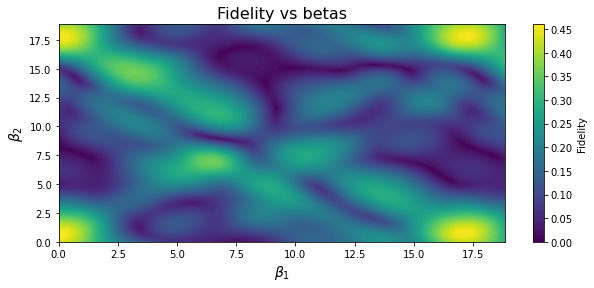

In [63]:
# Plotting the fidelity as a function of the first two modified betas
plt.figure(figsize=(10, 4))
plt.contourf(beta_1_range, beta_2_range, fidelity_map.T, levels=100, cmap='viridis')
plt.colorbar(label="Fidelity")
plt.xlabel(r"$\beta_1$", fontsize=14)
plt.ylabel(r"$\beta_2$", fontsize=14)
plt.title("Fidelity vs betas", fontsize=16)
plt.show()